# Prediction the temperature of stars

## Project description

Task from the observatory: use a neural network to determine the temperature on the surface of detected stars.

The observatory's database contains the characteristics of 240 stars that have already been studied.

## Project plan:

1. EDA. Prepare the data. Handle anomalies, missing values, duplicates.
2. Create a simple neural network and train it.
3. Make improvements to the neural network.
3. Analyze models and recommend the best for customer's criteria.

## Data description
__Features__:
- _Luminosity(L/Lo)_ — luminosity of a star relative to the Sun;
- _Radius(R/Ro)_ — radius of the star relative to the radius of the Sun;
- _Absolute magnitude(Mv)_ — physical quantity that characterizes brightness of a star;
- _Star type_ — type of star;
- _Star color_ — color of a star based on spectral analysis.

__Target feature__:
- _Temperature (K)_ — the temperature on the surface of the star in Kelvins;

## Loading and EDA

In [2]:
# pip install ydata-profiling
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from math import ceil
from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/datasets/6_class.csv', index_col=0)

df

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


Rename columns:

In [4]:
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

Data overview to EDA:

In [5]:
ProfileReport(df)

Conclusions after EDA:
- An equal number of objects of all types of stars.
- Implicit duplicates in the `star_color` column.
- Strong correlation of `temperature` with: `absolute_magnitude`, `star_type`.
- Strong correlation of `radius` with: `luminosity`, `absolute_magnitude`, `star_type`.
- Strong correlation of `absolute_magnitude` with: `luminosity`, `star_type`.
- Outgoing low/high values of numerical features (for example, temperature). But all within the limits of existing indicators.
- There are no missing values.

##  Preparing data

### Handling implicit duplicates in `star_color` column

In [6]:
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
Blue white              3
white                   3
Orange                  2
yellowish               2
Whitish                 2
Orange-Red              1
White-Yellow            1
Yellowish               1
Blue-White              1
Blue                    1
Pale yellow orange      1
Blue white              1
Name: star_color, dtype: int64

Get same color values to same writing:

In [7]:
df = df.replace({'star_color' : {'Blue White' : 'Blue-white',
                                 'Blue white' : 'Blue-white',
                                 'Blue-White' : 'Blue-white',
                                 'Blue white ': 'Blue-white',
                                 'Blue ': 'Blue',
                                 'white' : 'White',
                                 'yellow-white' : 'Yellow-white',
                                 'yellowish' : 'Yellowish',
                                 'Pale yellow orange' : 'Pale-yellow-orange'
                                }})

There are similar but not identical colors:

In [8]:
df[df['star_color'].isin(['Yellow-white', 'Yellowish White', 'Yellowish', 'White-Yellow', 'Orange', 'Orange-Red'])]

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
25,12990,0.000085,0.00984,12.230,2,Yellowish White
27,7700,0.000110,0.01280,14.470,2,Yellowish White
28,11790,0.000150,0.01100,12.590,2,Yellowish White
34,5800,0.810000,0.90000,5.050,3,Yellow-white
36,6757,1.430000,1.12000,2.410,3,Yellow-white
37,6380,1.350000,0.98000,2.930,3,Yellow-white
38,5936,1.357000,1.10600,4.460,3,Yellow-white
39,5587,0.819000,0.99000,5.030,3,Yellow-white
53,3749,550000.000000,1648.00000,-8.050,5,Orange
80,7100,0.000290,0.01200,14.090,2,White-Yellow


I will not replace them with similar values, for example, Yellowish White with Yellow-white. Because they have different types of stars and other signs. So it possible that there is different colors. Instead, I will combine all the rare colors into the `others` category.

In [9]:
df = df.replace(dict.fromkeys(['Yellowish White','Yellowish','Whitish','Orange', 'White-Yellow', 'Blue white', 'Pale-yellow-orange', 'Orange-Red'], 'Other'))

Color histogram:

<AxesSubplot:title={'center':'star_color distribution'}, xlabel='colors', ylabel='quantity'>

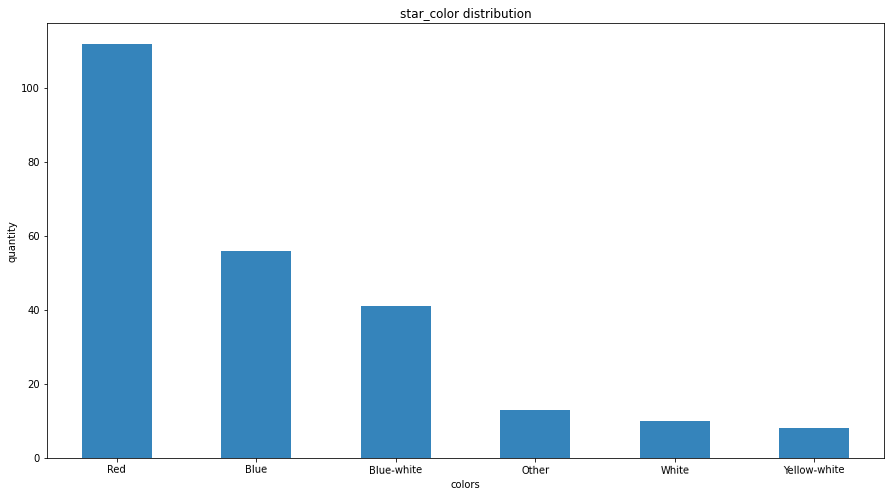

In [10]:
df['star_color'].value_counts().plot(kind='bar', title='star_color distribution', xlabel='colors', 
                                     ylabel='quantity', rot=1, alpha=0.9, figsize=(15,8))

### Preparation of features and sets

Split the data into training, validation, and test sets in a ratio of 60:20:20. 

Apply One-hot encoding for categorical features `star_type` and `star_color`, and scale all numerical features.

Create column transformers to encode categorical columns and scale numerical columns:

In [11]:
cat_cols = ['star_type', 'star_color']
num_cols = ['luminosity', 'radius', 'absolute_magnitude']

def create_sets(df, cat_cols, num_cols):
    features_train, target_train, features_valid, target_valid, features_test, target_test = split_set(df)
    features_train, features_valid, features_test = transform_sets(features_train, features_valid, features_test, cat_cols, num_cols)    
    
    return (torch.FloatTensor(features_train),
            torch.FloatTensor(features_valid),
            torch.FloatTensor(features_test),
            torch.FloatTensor(target_train.values).reshape(target_train.shape[0]),
            torch.FloatTensor(target_valid.values).reshape(target_valid.shape[0]),
            torch.FloatTensor(target_test.values).reshape(target_test.shape[0]))

def transform_sets(features_train, features_valid, features_test, cat_cols, num_cols):    
    col_trans = ColumnTransformer(transformers=[
        ('encoder', OneHotEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_cols)
    ])
    
    features_train = col_trans.fit_transform(features_train)
    features_valid = col_trans.transform(features_valid)
    features_test = col_trans.transform(features_test)
    
    return features_train, features_valid, features_test

def split_set(df):
    features_train, features_valid_test, target_train, target_valid_test = train_test_split(
        df.drop('temperature', axis=1), df['temperature'], test_size=0.4, random_state=142, shuffle=True)

    features_valid, features_test, target_valid, target_test = train_test_split(
        features_valid_test, target_valid_test, test_size=0.5, random_state=142, shuffle=True)
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

In [12]:
(features_train, features_valid, features_test, target_train, target_valid, target_test) = create_sets(df, cat_cols, num_cols)

## Building a basic neural network

The __ReLU__ activation function is better for the regression task. The __Kaiming Initialization__ (kaiming_normal_) is better suited for Rely. 

Class with architecture of a neural network with custom number of hidden layers:

In [13]:
class Net(nn.Module):
    def __init__(self, n_neurons, dropout_p=0.3):
        super(Net, self).__init__()
        
        self.layers = nn.ModuleList()
        
        for i in range(1, len(n_neurons) - 1):
            layer = nn.Linear(n_neurons[i-1], n_neurons[i])
            
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu', mode='fan_in')
            nn.init.normal_(layer.bias, mean=0.5, std=1)
            
            self.layers.append(layer)
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_p))
            
        layer = nn.Linear(n_neurons[-2], n_neurons[-1])
        nn.init.xavier_normal_(layer.weight)
        nn.init.normal_(layer.bias, mean=0.5, std=1)
        
        self.layers.append(layer)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

The function of training a neural network in epochs divided into butches:

In [14]:
def fit_net(net, num_epochs=500, batch_size=50):
    num_batches = ceil(len(features_train)/batch_size)

    random.seed(142)
    np.random.seed(142)
    torch.manual_seed(142)
    torch.use_deterministic_algorithms(True)

    
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    loss = nn.MSELoss()

    for epoch in range(num_epochs):
        order = np.random.permutation(len(features_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            features_train_batch = features_train[batch_indexes]
            target_train_batch = target_train[batch_indexes]

            preds = net.forward(features_train_batch).flatten()
            loss_value = loss(preds, target_train_batch)

            loss_value.backward()

            optimizer.step()

        if epoch % 20 == 0 or epoch == num_epochs - 1:
            net.eval()
            preds_valid = net.forward(features_valid)

            rmse = mean_squared_error(target_valid, preds_valid.detach().numpy(), squared=False)
            print(rmse)
    return net, rmse

Tried different number of hidden layers and neurons. Good results with a large number of hidden layers. But increase number of epochs resulted in overtraining:

In [15]:
n_neurons = [15, 60, 55, 50, 45, 40, 35, 30, 25, 20, 10, 8, 1]
net_baseline = Net(n_neurons)
net_baseline, rmse_valid_baseline = fit_net(net_baseline, num_epochs=300, batch_size=50)

12495.212
9613.244
6976.5674
5307.8696
4428.9233
4085.8125
4006.0562
4091.5178
4011.8662
4063.5476
3992.798
4008.4976
3983.592
4024.3723
4087.0237
4010.53


Function for plotting to compare predictions and real target values:

In [16]:
def drow_plot(target, preds):
    preds_np = preds.reshape(preds.shape[0]).detach().numpy()
    target_np = target.numpy()
    
    fig, ax = plt.subplots(figsize=[20,6])
    plt.bar(x=np.arange(len(preds_np)), height=preds_np, color='skyblue' , label='predicted')
    plt.bar(x=np.arange(len(target_np)), height=target_np, color='orange', label='real', width= 0.4)
    plt.xlabel('test_objects')
    plt.ylabel('temperature')
    ax.legend()
    plt.show()

## Improving the neural network

Adding iteration of the `batch_size` and `dropout` parameters:

In [17]:
batch_sizes = [40, 50, 60, 80]
dropout_params = [0.3, 0.5, 0.6]
n_neurons = [15, 60, 55, 50, 45, 40, 35, 30, 25, 20, 10, 8, 1]

best_rmse = 0

for batch_size in batch_sizes:
    for dropout_p in dropout_params:
        net_with_tuning_params = Net(n_neurons, dropout_p)
        net_with_tuning_params, rmse = fit_net(net_with_tuning_params, num_epochs=300, batch_size=batch_size)
        
        if rmse > best_rmse:
                best_rmse = rmse
                best_params = {'dropout_p': dropout_p, 'batch_size': batch_size}
                
print('best rmse of net_with_tuning_params:', rmse)
print('best params of net_with_tuning_params:', best_params)

12502.224
12501.119
12479.326
7343.076
5812.594
4578.764
4196.6094
4166.2363
4104.2446
4113.409
4085.4539
4106.2056
4132.341
4138.3857
4172.6475
4207.64
12510.52
12500.844
8260.922
5657.9575
4680.9727
4113.741
4053.6863
4056.869
4024.6028
4070.8381
4057.0076
4110.2617
4140.5635
4176.8843
4237.0913
4259.0513
12511.236
12501.201
12494.44
7020.6426
5089.1353
4185.2617
4060.8545
4025.945
4003.976
4044.773
4046.3318
4089.419
4092.7517
4111.6187
4189.004
4206.4575
12509.928
12470.241
7969.121
6131.4688
5132.508
4395.566
4053.6357
3993.626
3991.996
4001.2131
4018.4648
4040.535
4044.474
4078.2515
4087.3345
4084.3816
12502.395
12501.832
12501.347
12500.751
12479.107
7239.8784
5396.54
4398.1235
4241.159
4223.112
4210.824
4217.5483
4206.632
4225.5615
4224.649
4223.231
12502.57
12501.78
12501.284
12500.849
12498.365
7819.8066
6012.121
4593.8164
4220.6704
4183.827
4158.281
4180.2104
4191.6177
4220.616
4215.6807
4207.413
12502.266
12501.757
12501.241
8626.471
7231.529
5837.742
5026.339
4514.218
4270

RMSE improved just a little after tunining parameters. 

Best parameters: `dropout_p` = 0.5 and `batch_size` = 40.

Look at predictions on the test data:

rmse baseline net on test: 3683.6533


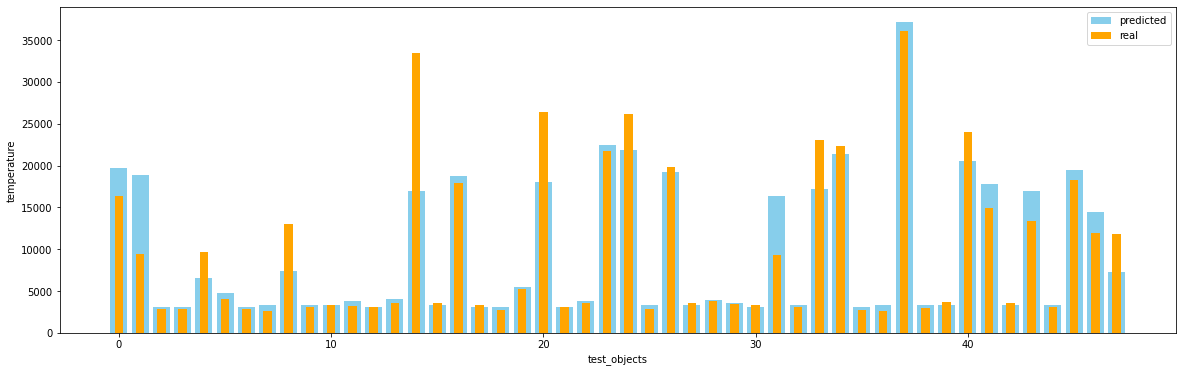

In [18]:
preds_test_baseline = net_baseline.forward(features_test)
rmse_test_baseline = mean_squared_error(target_test, preds_test_baseline.detach().numpy(), squared=False)


print('rmse baseline net on test:', rmse_test_baseline)
drow_plot(target_test, preds_test_baseline)

12500.007
8968.154
6831.0513
5324.241
4551.3228
4025.78
3968.7383
3978.3188
3941.3147
3896.777
3876.5242
3876.47
3852.6807
3845.7517
3907.4282
3866.572
rmse net with tuning params on test: 3657.5059


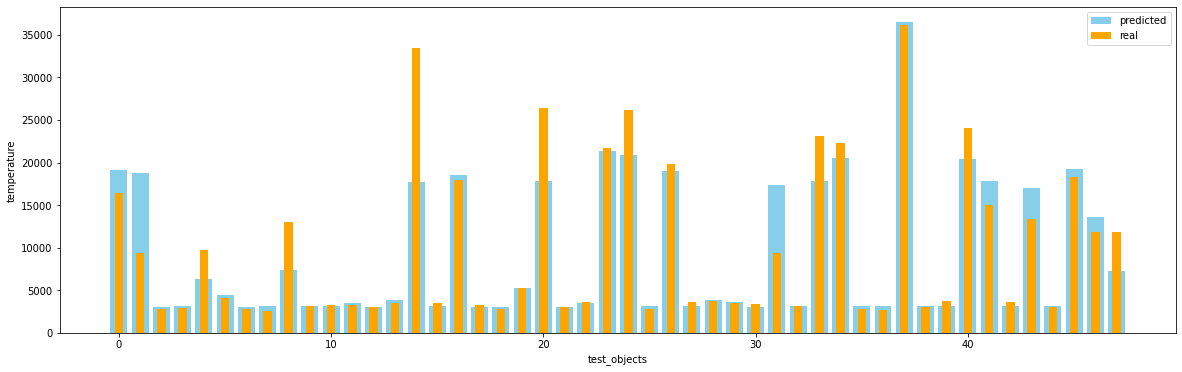

In [19]:
n_neurons = [15, 60, 55, 50, 45, 40, 35, 30, 25, 20, 10, 8, 1]
net_tuning_params_best = Net(n_neurons, best_params['dropout_p'])
net_tuning_params_best, rmse_valid_tuning_params_best = fit_net(net_tuning_params_best, 300, best_params['batch_size'])

preds_test_tuning_params_best = net_tuning_params_best.forward(features_test)
rmse_test_tuning_params_best = mean_squared_error(target_test, preds_test_tuning_params_best.detach().numpy(), squared=False)


print('rmse net with tuning params on test:', rmse_test_tuning_params_best)
drow_plot(target_test, preds_test_tuning_params_best)

Model after parameter tuning has a little better 

RMSE on the test data than base model. RMSE = 3658  on test data.

The graphs of the models are similar, both predict low temperatures well and large ones badly.

## Conclusion

- The data was preprocessed. Removed the implicit duplicates.
- Encoded categorical features and scaled numerical features.
- Built the base model of a neural network, found optimal number of hidden layers, neurons, activation function, initialization of weights.
- Improved the RMSE of the model by tuning the model parameters.
- The RMSE = 3658 of the improved model is on the test data.